In [1]:
%config Completer.use_jedi = False

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4329.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4223.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4253.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4190.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4354.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4136.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4226.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4214.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4888.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4170.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4323.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4262.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4788.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4657.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4387.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4255.jpg
/kaggle/

### Cat and Dog 데이터세트의 디렉토리와 파일을 기반으로 dataframe 생성

In [3]:
import pandas as pd
import os

def make_catndog_dataframe():
    paths = []
    dataset_gubuns = []
    label_gubuns = []
    
    for dirname, _, filenames in os.walk('/kaggle/input/cat-and-dog'):
        for filename in filenames:
            # 이미지 파일만 걸러내기
            if '.jpg' in filename:
                file_path = dirname + '/' + filename
                paths.append(file_path)
                # 파일의 절대 경로에 training set, test set가 포함되어 있으면 데이터 세트 구분을 training과 test로 구분
                if '/training_set/' in file_path:
                    # 파일의 절대 경로를 file_path 변수에 할당
                    dataset_gubuns.append('train')
                elif '/test_set/' in file_path:
                    dataset_gubuns.append('test')
                else:
                    dataset_gubuns.append('N/A')
                    
                # 파일의 절대 경로에 dogs가 있을 경우 해당 파일은 dog이미지, cats의 경우는 cat 이미지
                if 'dogs' in file_path:
                    label_gubuns.append('DOG')
                elif 'cats' in file_path:
                    label_gubuns.append('CAT')
                else:
                    label_gubuns.append('N/A')
    
    data_df = pd.DataFrame({'path':paths, 'dataset':dataset_gubuns, 'label':label_gubuns})
    return data_df

In [4]:
pd.reset_option('display.max_colwidth', 200)
data_df = make_catndog_dataframe()
print(data_df.shape)
data_df.head(10)

(10028, 3)


,path,dataset,label
0,/kaggle/input/cat-and-dog/test_set/test_set/do...,test,DOG
1,/kaggle/input/cat-and-dog/test_set/test_set/do...,test,DOG
2,/kaggle/input/cat-and-dog/test_set/test_set/do...,test,DOG
3,/kaggle/input/cat-and-dog/test_set/test_set/do...,test,DOG
4,/kaggle/input/cat-and-dog/test_set/test_set/do...,test,DOG
5,/kaggle/input/cat-and-dog/test_set/test_set/do...,test,DOG
6,/kaggle/input/cat-and-dog/test_set/test_set/do...,test,DOG
7,/kaggle/input/cat-and-dog/test_set/test_set/do...,test,DOG
8,/kaggle/input/cat-and-dog/test_set/test_set/do...,test,DOG
9,/kaggle/input/cat-and-dog/test_set/test_set/do...,test,DOG


### Keras Sequence를 상속받은 Dataset 객체를 생성
1. 과정을 요약하자면 이미지 dataset 객체를 생성하기 위해 이미지의 절대 경로와 labels를 batch size에 맞게 받는다
2. 받은 데이터들을 이미지로 뽑아내고 resize를 거친 후 augmentation 적용
3. 이후에 사전에 image_batch를 받기 위해 np.zeros 형태로 만들어둔 공간에 넣고 return한다.

In [5]:
from tensorflow.keras.utils import Sequence
import sklearn
import cv2

# 배치 크기와 사이즈를 전역 변수로 선언
BATCH_SIZE = 64
IMAGE_SIZE = 224

# 입력 인자 image_filename, labels는 모두 numpy array로 넣어준다.
class CnD_Dataset(Sequence):
    
    # 객체 생성  인자로 들어온 값을 객체 내부 변수로 할당
    def __init__(self, image_filenames, labels, batch_size=BATCH_SIZE, augmentor=None, shuffle=False):
        '''
        파라미터 설명
        image_filenames: opencv로 image를 로드할 파일의 절대 경로들
                         이미지 array를 받을 경우 사이즈가 너무 커서 대신 경로를 받아온다.
        labels: 로드할 image들의 label들
        batch_size: __getitem__(self, index) 호출하는 때마다 갖고 올 batch 건수
        augmentor: albumetations 객체
        shuffle: 학습 데이터의 경우 epoch 종료시마다 데이터의 혼합 여부
        '''
        
        # 객체 생성 인자로 들어온 값을 객체 내부 변수로 할당
        self.image_filenames = image_filenames
        self.labels = labels
        self.batch_size = batch_size
        self.augmentor = augmentor
        self.shuffle = shuffle
        # train data인 경우
        if self.shuffle:
            pass
        
    def __len__(self):
        # batch size단위로 데이터를 몇 번 갖고오는지 계산하기 위해 전체 데이터 건수를 batch size로 나누고 나누어 떨어지지 않을 시 + 1
        return int(np.ceil(len(self.labels) / self.batch_size))
        
    def __getitem__(self, index):
        # image array, label array 데이터를 batch size 단위로 갖고 와서 변환한 뒤에 다시 반환
        # 인자로 몇 번째 batch인지 나타내는 index를 입력하면 해당 순서에 해당하는 batch size 만큼의 데이터를 가공해 반환
        # batch size 개수만큼 변환된 image array와 label array 반환
            
        # index는 몇 번째 batch인지 나타낸다.
        # batch size만큼 순차적으로 데이터를 갖고오려면 array에서 index * self.batch_size:(index+1)*self.batch_size 만큼의 데이터를 갖고오면 된다.
        image_name_batch = self.image_filenames[index*self.batch_size:(index+1)*self.batch_size]
        label_batch = self.labels[index*self.batch_size:(index+1)*self.batch_size]
            
        # 만일 객체 생성 인자로 albumentation으로 만든 augmentor가 주어진다면 아래와 같이 augmentor를 이용해 image 변환
        # albumentation은 개별 image만 변환활 수 있으므로 batch size만큼 할당된 image_name_batch 한 건씩 iteration하면서 변환 수행
        # image_batch 배열은 float32로 설정
        # 여기서 zeros 배열의 첫 인자로 왜 batch_size를 안 줬냐면 데이터 수가 batchsize만큼 나누어 떨어지지 않을 경우를 대비하기 위해서다.
        image_batch = np.zeros((image_name_batch.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
        # batch size에 담긴 건수만큼 iteration하면서 opencv image load -> image augmentation -> image batch에 담는다.
        for image_index in range(image_name_batch.shape[0]):
            image = cv2.cvtColor(cv2.imread(image_name_batch[image_index]), cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
            if self.augmentor is not None:
                image = self.augmentor(image=image)['image']
                    
            image_batch[image_index] = image
                
        return image_batch, label_batch
        
        # epoch가 한 번 수행이 왼료되는 때마다 모델의 fit()에서 호출된다.
    def on_epoch_end(self):
        if self.shuffle:
            self.image_filenames, self.labels = sklearn.utils.shuffle(self.image_filenames, self.labels)
        else:
            pass

2024-03-01 12:22:09.848383: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-01 12:22:09.848497: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-01 12:22:09.996178: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Sequence 기반 Dataset을 생성하고 호출하기
* albumentation을 이용해 batch 크기 만큼 데이터를 augmenation 한 뒤에 데이터를 반환할 수 있는 Sequence 기반 dataset을 생성하고 호출한다.

In [6]:
data_df.head(10)

,path,dataset,label
0,/kaggle/input/cat-and-dog/test_set/test_set/do...,test,DOG
1,/kaggle/input/cat-and-dog/test_set/test_set/do...,test,DOG
2,/kaggle/input/cat-and-dog/test_set/test_set/do...,test,DOG
3,/kaggle/input/cat-and-dog/test_set/test_set/do...,test,DOG
4,/kaggle/input/cat-and-dog/test_set/test_set/do...,test,DOG
5,/kaggle/input/cat-and-dog/test_set/test_set/do...,test,DOG
6,/kaggle/input/cat-and-dog/test_set/test_set/do...,test,DOG
7,/kaggle/input/cat-and-dog/test_set/test_set/do...,test,DOG
8,/kaggle/input/cat-and-dog/test_set/test_set/do...,test,DOG
9,/kaggle/input/cat-and-dog/test_set/test_set/do...,test,DOG


In [7]:
import albumentations as A

# 전체 데이터 세트에서 학습과 테스트용 메타 정보 dataframe 사용
train_df = data_df[data_df['dataset']=='train']
test_df = data_df[data_df['dataset']=='test']

# image file의 위치가 있는 데이터와 label 값을 numpy array로 변환
# 예를 들어 train_df['path']에 values 안 붙여주면 Series 형태로 나오는데, 이걸 numpy 형태로 바꾸기 위한 작업이다.
train_image_filenames = train_df['path'].values
train_image_labels = train_df['label'].values

cnd_augmentor = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5)
])

# Sequence를 상속받은 CnD_dataset를 iamge 파일 위치, label 값, albumentations 변환 객체를 입력하여 생성
cnd_ds = CnD_Dataset(train_image_filenames, train_image_labels, batch_size=BATCH_SIZE, augmentor=cnd_augmentor, shuffle=False)


In [8]:
train_image_filenames.shape

(8005,)

In [9]:
images_batch = next(iter(cnd_ds))[0]
labels_batch = next(iter(cnd_ds))[1]
print(images_batch.shape, labels_batch.shape)
print(images_batch[0])

images_batch[0,100,70,2].dtype

(64, 224, 224, 3) (64,)
[[[188. 179. 162.]
  [186. 177. 160.]
  [184. 175. 158.]
  ...
  [199. 196. 179.]
  [198. 195. 178.]
  [196. 193. 176.]]

 [[189. 180. 163.]
  [186. 177. 160.]
  [185. 176. 159.]
  ...
  [195. 192. 175.]
  [196. 193. 176.]
  [196. 193. 176.]]

 [[190. 180. 163.]
  [186. 176. 159.]
  [186. 176. 159.]
  ...
  [193. 190. 173.]
  [194. 191. 174.]
  [197. 194. 177.]]

 ...

 [[239. 235. 226.]
  [241. 237. 228.]
  [245. 241. 232.]
  ...
  [241. 237. 226.]
  [242. 239. 227.]
  [244. 240. 229.]]

 [[239. 235. 226.]
  [241. 237. 228.]
  [245. 241. 232.]
  ...
  [242. 239. 227.]
  [243. 239. 228.]
  [244. 240. 229.]]

 [[239. 235. 226.]
  [242. 238. 229.]
  [245. 241. 232.]
  ...
  [241. 237. 226.]
  [243. 239. 228.]
  [244. 240. 229.]]]


dtype('float64')

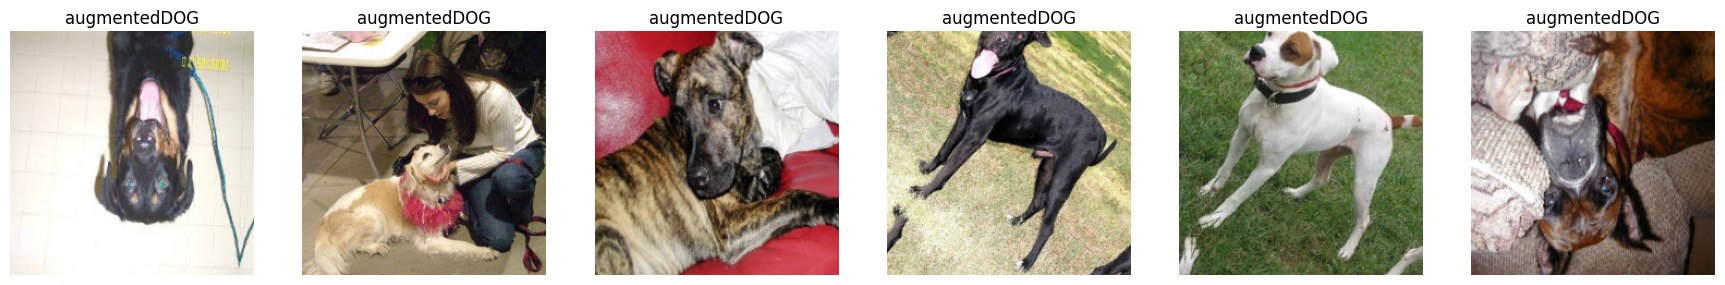

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_grid_images(images_batch, ncols=4, title=None):
    figure, axs = plt.subplots(figsize=(22,4), nrows=1, ncols=ncols)
    for i in range(ncols):
        # images_batch 안에 개별적인 값은 float64로 되어 있는데 공식문서에서 보면 imshow에서 받아주는 숫자 타입은 0-1 float or 0-255 int이라 이거 맞춰줘야 한다.
        axs[i].imshow(np.array(images_batch[i], dtype='int32'))
        axs[i].axis('off')
        axs[i].set_title(title[i])
        
show_grid_images(images_batch, ncols=6, title='augmented' + labels_batch)

### 원본 이미지 픽셀값의 scaling을 감안하여 다시 CnD_Dataset 재작성

In [11]:
# 입력 인자 image_filenames, labels는 모두 numpy array로 들어옴
class CnD_Dataset(Sequence):
    def __init__(self, image_filenames, labels, batch_size=BATCH_SIZE, augmentor=None, shuffle=False):
        '''
        파라미터 설명
        image_filenames: opencv로 image를 로드할 파일의 절대 경로들
        labels: 해당 image의 label들
        batch_size: __getitem__(self, index) 호출 시 마다 가져올 데이터 batch 건수
        augmentor: albumentations 객체
        shuffle: 학습 데이터의 경우 epoch 종료시마다 데이터를 섞을지 여부
        '''
        # 객체 생성 인자로 들어올 값을 객체 내부 변수로 할당
        self.image_filenames = image_filenames
        self.labels = labels
        self.batch_size = batch_size
        self.augmentor = augmentor
        # train data의 경우 
        self.shuffle = shuffle
        if self.shuffle:
            # 객체 생성시에 한번 데이터를 섞음. 
            #self.on_epoch_end()
            pass
    
    # Sequence를 상속받은 Dataset은 batch_size 단위로 입력된 데이터를 처리함. 
    # __len__()은 전체 데이터 건수가 주어졌을 때 batch_size단위로 몇번 데이터를 반환하는지 나타남
    def __len__(self):
        return int(np.ceil(len(self.labels) / BATCH_SIZE))
    
    
    # batch_size 단위로 image_array, label_array 데이터를 가져와서 변환한 뒤 다시 반환함
    # 인자로 몇번째 batch 인지를 나타내는 index를 입력하면 해당 순서에 해당하는 batch_size 만큼의 데이타를 가공하여 반환
    # batch_size 갯수만큼 변환된 image_array와 label_array 반환. 
    def __getitem__(self, index):
        # index는 몇 번째 batch인지릃 나타낸다
        image_name_batch = self.image_filenames[index*self.batch_size:(index+1)*self.batch_size]
        if self.labels is not None:
            label_batch = self.labels[index*self.batch_size:(index+1)*self.batch_size]
        
        # 만일 객체 생성 인자로 albumentation으로 만든 augmentor가 주어진다면 아래와 같이 augmentor를 이용하여 image 변환
        # albumentations은 개별 image만 변환할 수 있으므로 batch_size만큼 할당된 image_name_batch를 한 건씩 iteration하면서 변환 수행. 
        # image_batch 배열은 float32 로 설정. 
        image_batch = np.zeros((image_name_batch.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3), dtype='float32')
        
        # batch_size에 담긴 건수만큼 iteration 하면서 opencv image load -> image augmentation 변환(augmentor가 not None일 경우)-> image_batch에 담음. 
        for image_index in range(image_name_batch.shape[0]):
            image = cv2.cvtColor(cv2.imread(image_name_batch[image_index]), cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
            if self.augmentor is not None:
                image = self.augmentor(image=image)['image']
            
            # 이전 class와 달리 새롭게 추가된 부분
            # 이미지 값을 0 ~ 1 로 스케일링. 
            image = image/255.0
                
            image_batch[image_index] = image
        
        return image_batch, label_batch
    
    # epoch가 한번 수행이 완료 될 때마다 모델의 fit()에서 호출됨. 
    def on_epoch_end(self):
        if(self.shuffle):
            #print('epoch end')
            # 전체 image 파일의 위치와 label를 쌍을 맞춰서 섞어준다. scikt learn의 utils.shuffle에서 해당 기능 제공
            self.image_filenames, self.labels = sklearn.utils.shuffle(self.image_filenames, self.labels)
        else:
            pass

In [12]:
# Sequence를 상속받은 CnD_Dataset를 image 파일 위치, label값, albumentations 변환 객체를 입력해 생성
cnd_ds = CnD_Dataset(train_image_filenames, train_image_labels, batch_size=BATCH_SIZE, augmentor=cnd_augmentor, shuffle=False)

images_batch = next(iter(cnd_ds))[0]
labels_batch = next(iter(cnd_ds))[1]
print(images_batch.shape, labels_batch.shape)
print(images_batch[0])

(64, 224, 224, 3) (64,)
[[[0.72156864 0.7058824  0.60784316]
  [0.7137255  0.69803923 0.6       ]
  [0.7137255  0.69803923 0.6       ]
  ...
  [0.7137255  0.68235296 0.6039216 ]
  [0.7294118  0.69803923 0.62352943]
  [0.7372549  0.7058824  0.6313726 ]]

 [[0.7176471  0.7019608  0.6039216 ]
  [0.7137255  0.69803923 0.6       ]
  [0.70980394 0.69411767 0.59607846]
  ...
  [0.7137255  0.6784314  0.6117647 ]
  [0.7294118  0.69411767 0.627451  ]
  [0.7372549  0.7058824  0.6392157 ]]

 [[0.72156864 0.7058824  0.60784316]
  [0.7176471  0.7019608  0.6039216 ]
  [0.7137255  0.69803923 0.6039216 ]
  ...
  [0.7176471  0.68235296 0.6117647 ]
  [0.73333335 0.69803923 0.6313726 ]
  [0.7411765  0.7058824  0.6392157 ]]

 ...

 [[0.8745098  0.85882354 0.8156863 ]
  [0.8901961  0.8745098  0.83137256]
  [0.8980392  0.88235295 0.8392157 ]
  ...
  [0.93333334 0.90588236 0.8745098 ]
  [0.93333334 0.90588236 0.8745098 ]
  [0.93333334 0.90588236 0.8745098 ]]

 [[0.87058824 0.85490197 0.8117647 ]
  [0.88235295

### Pretrained 모델에서 사용하는 보다 범용적인 Processing을 적용할 수 있도록 개선.
* 앞에서처럼 단순히 image array를 255로 나누기엔 아쉬운 점이 많다.
* 우선 pretrained 모델별로 각자 요구되는 scaling 방식 등 원하는 모습이 다르다.
* 그래서 각 모델에 맞는 preprocessing 함수를 넣어 preprocessing을 진행하는 것이 더 효율적이다.

In [13]:
# 입력 인자 image_filenames, labels는 모두 numpy array로 갖고 온다.
class CnD_Dataset(Sequence):
    def __init__(self, image_filenames, labels, batch_size=BATCH_SIZE, augmentor=None, shuffle=False, pre_func=None):
        '''
        파라미터 설명
        image_filenames: opencv로 image를 로드할 파일의 절대 경로들
        labels: 해당 image의 label들
        batch_size: __getitem__(self, index) 호출 시 마다 가져올 데이터 batch 건수
        augmentor: albumentation 진행
        shuffle: 학습 데이터의 경우 epoch 종료시마다 데이터를 섞을지 여부
        '''
        
        # 객체 생성 인자로 들어온 값을 객체 내부 변수로 할당
        self.image_filenames = image_filenames
        self.labels = labels
        self.batch_size=batch_size
        self.augmentor = augmentor
        self.pre_func = pre_func
        # train 데이터의 경우
        self.shuffle = shuffle
        if self.shuffle:
            pass
        
    def __len__(self):
        # batch size 단위로 데이터를 몇 번 가져와야 하는지 계산하기 위해 데이터 건수를 batch_size로 나누다.
        return int(np.ceil(len(self.labels)/self.batch_size))
    
    # batch size 단위로 image_array, label_array 데이터를 가져와서 변환한 뒤 다시 반환
    # 인자로 몇 번째 batch 인지를 나타내는 index를 입력하면 해당 순서에 해당하는 batch size 만큼의 데이터를 가공하여 반환
    # batch_size 개수만큼 변환된 image_array와 label_array 반환
    def __getitem__(self, index):
        # index는 몇 번째 batch인지를 나타낸다.
        image_name_batch = self.image_filenames[index*self.batch_size:(index+1)*self.batch_size]
        label_batch = self.labels[index*self.batch_size:(index+1)*self.batch_size]
        
        # 만일 객체 생성 인자로 albumentation을 만든 augmentor가 주어진다면 아래와 같이 augmentor를 이용하여 image 반환
        # albumentation은 개별 image만 반환할 수 있으므로 batch_size만큼 할당된 image_name_batch를 한 건 단위로 iteration하여 수행
        # image_batch 배열은 float32로 설정
        image_batch = np.zeros((image_name_batch.shape[0], IMAGE_SIZE, IMAGE_SIZE,3), dtype='float32')
        
        # batch_size에 담긴 건수만큼 iteration 하면서 opencv image load -> image augmentation 변환 -> image_batch에 담음
        for image_index in range(image_name_batch.shape[0]):
            image = cv2.cvtColor(cv2.imread(image_name_batch[image_index]), cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
            if self.augmentor is not None:
                image = self.augmentor(image=image)['image']
                
            # 만일 preprocessing_input이 pre_func 인자로 들어오면 이를 이용하여 scaling 적용.
            if self.pre_func is not None:
                image = self.pre_func(image)
                
            image_batch[image_index] = image
            
        return image_batch, label_batch
    
    def on_epoch_end(self):
        if (self.shuffle):
            self.image_filenames, self.labels = sklearn.utils.shuffle(self.image_filenames, self.labels)
        else:
            pass

In [14]:
from tensorflow.keras.applications.xception import preprocess_input as xcp_preprocess_input

cnd_ds = CnD_Dataset(train_image_filenames, train_image_labels, batch_size=BATCH_SIZE, 
                     augmentor=cnd_augmentor, shuffle=False, pre_func=xcp_preprocess_input)

image_batch = next(iter(cnd_ds))[0]
label_batch = next(iter(cnd_ds))[1]
print(image_batch.shape, label_batch.shape)
print(image_batch[0:2])

(64, 224, 224, 3) (64,)
[[[[ 0.7411765   0.70980394  0.62352943]
   [ 0.7490196   0.7176471   0.6313726 ]
   [ 0.7411765   0.70980394  0.62352943]
   ...
   [ 0.85882354  0.8039216   0.7411765 ]
   [ 0.85882354  0.8039216   0.7411765 ]
   [ 0.85882354  0.8039216   0.7411765 ]]

  [[ 0.7411765   0.70980394  0.62352943]
   [ 0.7647059   0.73333335  0.64705884]
   [ 0.75686276  0.7254902   0.6392157 ]
   ...
   [ 0.85882354  0.8039216   0.7411765 ]
   [ 0.85882354  0.8039216   0.7411765 ]
   [ 0.85882354  0.8039216   0.7411765 ]]

  [[ 0.7490196   0.7176471   0.6313726 ]
   [ 0.78039217  0.7490196   0.6627451 ]
   [ 0.79607844  0.7647059   0.6784314 ]
   ...
   [ 0.8666667   0.8117647   0.7490196 ]
   [ 0.8666667   0.8117647   0.7490196 ]
   [ 0.8666667   0.8117647   0.7490196 ]]

  ...

  [[ 0.4431373   0.41176474  0.21568632]
   [ 0.43529415  0.4039216   0.20784318]
   [ 0.427451    0.39607847  0.20784318]
   ...
   [ 0.43529415  0.36470592  0.22352946]
   [ 0.4666667   0.39607847  0.26

### 별도의 preprocessing 함수나 Albumentation의 Normalize 적용 가능

In [15]:
cnd_augmentor = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5)
])

def zero_one_scaler(image):
    return image/255.0

cnd_ds = CnD_Dataset(train_image_filenames, train_image_labels, batch_size=BATCH_SIZE,
                    augmentor=cnd_augmentor, shuffle=False, pre_func=zero_one_scaler)

image_batch = next(iter(cnd_ds))[0]
label_batch = next(iter(cnd_ds))[1]

image_batch[0:2]

array([[[[0.7647059 , 0.7411765 , 0.6745098 ],
         [0.76862746, 0.7490196 , 0.6784314 ],
         [0.76862746, 0.7490196 , 0.68235296],
         ...,
         [0.78039217, 0.7411765 , 0.6901961 ],
         [0.7764706 , 0.7372549 , 0.6862745 ],
         [0.78039217, 0.7411765 , 0.69411767]],

        [[0.7647059 , 0.74509805, 0.67058825],
         [0.77254903, 0.7529412 , 0.6784314 ],
         [0.7647059 , 0.74509805, 0.67058825],
         ...,
         [0.78431374, 0.74509805, 0.69803923],
         [0.7764706 , 0.7372549 , 0.6901961 ],
         [0.78039217, 0.7411765 , 0.69411767]],

        [[0.7607843 , 0.74509805, 0.67058825],
         [0.76862746, 0.7490196 , 0.6745098 ],
         [0.7647059 , 0.74509805, 0.67058825],
         ...,
         [0.7882353 , 0.7490196 , 0.7019608 ],
         [0.78039217, 0.7411765 , 0.69411767],
         [0.78039217, 0.7411765 , 0.69411767]],

        ...,

        [[0.89411765, 0.8784314 , 0.8352941 ],
         [0.9098039 , 0.89411765, 0.8509804 ]

In [16]:
# 다른 방식으로 augmentor 안에 normalizing을 넣을 수 있다

cnd_augmentor_normalized = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5),
    # albumentation의 normalize를 통해 각 채널 별로 평균값과 표준편차 값을 설정할 수 있다.
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])
cnd_ds = CnD_Dataset(train_image_filenames, train_image_labels, batch_size=BATCH_SIZE,
                    augmentor=cnd_augmentor_normalized, shuffle=False, pre_func=None)
image_batch = next(iter(cnd_ds))[0]
label_batch = next(iter(cnd_ds))[1]
image_batch[0]

array([[[1.6837913 , 1.7808123 , 1.8033987 ],
        [1.700916  , 1.7983192 , 1.8208278 ],
        [1.6837913 , 1.7808123 , 1.8033987 ],
        ...,
        [1.9406626 , 1.9908962 , 2.0648365 ],
        [1.9406626 , 1.9908962 , 2.0648365 ],
        [1.9406626 , 1.9908962 , 2.0648365 ]],

       [[1.6837913 , 1.7808123 , 1.8033987 ],
        [1.7351656 , 1.8333333 , 1.8556863 ],
        [1.7180408 , 1.8158263 , 1.8382571 ],
        ...,
        [1.9406626 , 1.9908962 , 2.0648365 ],
        [1.9406626 , 1.9908962 , 2.0648365 ],
        [1.9406626 , 1.9908962 , 2.0648365 ]],

       [[1.700916  , 1.7983192 , 1.8208278 ],
        [1.7694151 , 1.8683473 , 1.8905447 ],
        [1.8036646 , 1.9033612 , 1.925403  ],
        ...,
        [1.9577874 , 2.0084033 , 2.0822659 ],
        [1.9577874 , 2.0084033 , 2.0822659 ],
        [1.9577874 , 2.0084033 , 2.0822659 ]],

       ...,

       [[1.0330507 , 1.1155462 , 0.8970806 ],
        [1.015926  , 1.0980392 , 0.8796514 ],
        [0.9988012 , 1

### 학습, 검증 데이터 분할 및 레이블 인코딩 적용
* 분할 및 레이블 인코딩은 Sequence class 안이 아닌, 밖에서 적용하자.
* 클래스 안이 지나치게 복잡해지는 것을 지양하기 위해서다.

In [17]:
# 원 핫 인코딩
labels_ohe = pd.get_dummies(train_df['label']).values # values를 통해 dataframe을 array 형태로 뽑아내자
print(labels_ohe[:5])

# 일반 레이블 인코딩
labels_enc = pd.factorize(train_df['label'])[0]  # tuple인데 array 형태로 뽑아내자
print(labels_enc[:5])

print(labels_ohe.shape, labels_enc.shape)

[[False  True]
 [False  True]
 [False  True]
 [False  True]
 [False  True]]
[0 0 0 0 0]
(8005, 2) (8005,)


In [18]:
from sklearn.model_selection import train_test_split

# 학습 데이터와 테스트 데이터용 dataframe 생성
train_df = data_df[data_df['dataset']=='train']
test_df = data_df[data_df['dataset']=='test']

# 학습 데이터의 image path와 label을 numpy array로 변환 및 label encoding
train_path = train_df['path'].values
# 참고로 이번 모델은 sigmoid를 쓸 예정이니 one hot encoding이 아닌 일반 레이블로 생성
train_label = pd.factorize(train_df['label'])[0]

# train_path는 참고로 절대경로다.
tr_path, val_path, tr_label, val_label = train_test_split(train_path, train_label, test_size=0.15, random_state=42)
print(tr_path.shape, tr_label.shape)
print(val_path.shape, val_label.shape)

(6804,) (6804,)
(1201,) (1201,)


In [19]:
cnd_augmentor = A.Compose([
    A.HorizontalFlip(p=0.3)
])

In [20]:
from tensorflow.keras.applications.xception import preprocess_input as xcp_preprocess_input

tr_ds = CnD_Dataset(tr_path, tr_label, batch_size=BATCH_SIZE, augmentor=cnd_augmentor, 
                      shuffle=True, pre_func=xcp_preprocess_input)
val_ds = CnD_Dataset(val_path, val_label, batch_size=BATCH_SIZE, augmentor=None, 
                       shuffle=False, pre_func=xcp_preprocess_input)

tr_image_batch = next(iter(tr_ds))[0]
val_image_batch = next(iter(val_ds))[0]
print(tr_image_batch.shape, val_image_batch.shape)

print(tr_image_batch[:1])
print(val_image_batch[:1])


(64, 224, 224, 3) (64, 224, 224, 3)
[[[[-0.5529412  -0.38039213 -0.5686275 ]
   [-0.45098037 -0.25490195 -0.4823529 ]
   [-0.19999999  0.02745104 -0.24705881]
   ...
   [-0.30196077 -0.16862744 -0.09803921]
   [-0.2235294  -0.08235294 -0.05098039]
   [ 0.09019613  0.23921573  0.22352946]]

  [[-0.5764706  -0.38039213 -0.6       ]
   [-0.6392157  -0.4352941  -0.6627451 ]
   [-0.7411765  -0.5137255  -0.75686276]
   ...
   [-0.2862745  -0.15294117 -0.08235294]
   [-0.19999999 -0.05882353 -0.01176471]
   [ 0.082353    0.22352946  0.24705887]]

  [[-0.47450978 -0.23137254 -0.5058824 ]
   [-0.5921569  -0.35686272 -0.58431375]
   [-0.6784314  -0.4588235  -0.6392157 ]
   ...
   [-0.27843136 -0.15294117 -0.04313725]
   [-0.17647058 -0.04313725  0.03529418]
   [ 0.082353    0.21568632  0.27058828]]

  ...

  [[ 0.2941177   0.27058828  0.14509809]
   [ 0.4431373   0.427451    0.28627455]
   [ 0.35686278  0.35686278  0.21568632]
   ...
   [-0.03529412 -0.02745098 -0.09019607]
   [-0.0745098  -0.05

### 모델 생성

In [21]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, Flatten, Activation, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.applications import VGG16, ResNet50V2, Xception, MobileNetV2

def create_model(model_name='vgg16', verbose=False):
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    if model_name == 'vgg16':
        base_model = VGG16(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'resnet50':
        base_model = ResNet50V2(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'xception':
        base_model = Xception(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'mobilenet':
        base_model = MobileNetV2(input_tensor=input_tensor, include_top=False, weights='imagenet')
    
    bm_output = base_model.output
    
    x = GlobalAveragePooling2D()(bm_output)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
    x = Dense(50, activation='relu', name='fc1')(x)
    # 최종 output 출력은 sigmoid라서 one hot encoding은 적용하지 않는다.
    output = Dense(1, activation='sigmoid', name='output')(x)
    
    model = Model(inputs=input_tensor, outputs=output)
    
    if verbose:
        model.summary()
        
    return model
    

In [22]:
import tensorflow as tf

tf.keras.backend.clear_session()

model = create_model(model_name='xception')
# 최종 output 출력이 sigmoid이므로 bianry_corssentorpy 적용
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, mode='min', verbose=1)
ely_cb = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)

83683744/83683744 [==============================] - 0s 0us/step


In [23]:
# keras sequence를 통해 inputs이랑 targets 값을 던졌다.

N_EPOCHS = 10
history = model.fit(tr_ds, epochs=N_EPOCHS,
                   validation_data=val_ds,
                   callbacks=([rlr_cb, ely_cb]), verbose=1)

Epoch 1/10


I0000 00:00:1709295772.509487      72 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


107/107 [==============================] - 125s 804ms/step - loss: 0.1238 - accuracy: 0.9527 - val_loss: 7.5934 - val_accuracy: 0.6828 - lr: 0.0010
Epoch 2/10
107/107 [==============================] - 62s 574ms/step - loss: 0.0618 - accuracy: 0.9777 - val_loss: 0.1813 - val_accuracy: 0.9467 - lr: 0.0010
Epoch 3/10
107/107 [==============================] - 60s 554ms/step - loss: 0.0431 - accuracy: 0.9840 - val_loss: 0.1741 - val_accuracy: 0.9500 - lr: 0.0010
Epoch 4/10
107/107 [==============================] - 63s 584ms/step - loss: 0.0404 - accuracy: 0.9862 - val_loss: 0.0833 - val_accuracy: 0.9775 - lr: 0.0010
Epoch 5/10
107/107 [==============================] - 65s 605ms/step - loss: 0.0272 - accuracy: 0.9906 - val_loss: 0.1108 - val_accuracy: 0.9584 - lr: 0.0010
Epoch 6/10
107/107 [==============================] - 61s 566ms/step - loss: 0.0240 - accuracy: 0.9909 - val_loss: 0.2852 - val_accuracy: 0.9217 - lr: 0.0010
Epoch 7/10
107/107 [==============================] - ETA: 0s 

### 성능 평가

In [24]:
test_df = data_df[data_df['dataset']=='test']

# 테스트 데이터의 image path와 labels를 numpy array로 변환 및 label encoding
test_path = test_df['path'].values
test_label = pd.factorize(test_df['label'])[0]

test_ds = CnD_Dataset(test_path, test_label, batch_size=BATCH_SIZE, augmentor=None, 
                       shuffle=False, pre_func=xcp_preprocess_input)

model.evaluate(test_ds)

32/32 [==============================] - 23s 714ms/step - loss: 0.0558 - accuracy: 0.9837


[0.055801644921302795, 0.9836875796318054]